# Load data from Drive

In [ ]:
# # Reading the data from Git
# # get the data at: http://www.manythings.org/anki/

# !apt-get install git-lfs git
# !git clone https://github.com/PratishMashankar/cs747gmudl.git
# !git config --global user.email "psmashankar@gmail.com" #change this with your email
# !git config --global user.name "Pratish Mashankar" #change this with your name

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os, sys
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

# Config

In [ ]:
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 50

# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

# Reading Data

In [ ]:
# Read the data
t = 0
for line in open('/content/fra.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


# Data Preprocess
Creating input output sentences

Padding

Storing pretratined vectors from Glove embeddings, creating embedding matrix,and layers



## Input Sequence

In [ ]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
print('Maximum length of input sequence: ', max_len_input)

Found 2031 unique input tokens.
Maximum length of input sequence:  4


## Output Sequence

In [ ]:
# tokenize the outputs
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
num_words_output = len(word2idx_outputs) + 1 # remember to add 1 since indexing starts at 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
print('Maximum length of output sequence: ', max_len_target)

Found 5590 unique output tokens.
Maximum length of output sequence:  11


## Padding

In [ ]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 4)
encoder_inputs[0]: [ 0  0  0 10]
decoder_inputs[0]: [ 2 41  4  0  0  0  0  0  0  0  0]
decoder_inputs.shape: (10000, 11)


## Pretrained embeddings

In [ ]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

print("Embedding layer created")

Loading word vectors...
Found 400000 word vectors.
Filling pre-trained embeddings...
Embedding layer created


## Creating one hot encodings for decoder targets

In [ ]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

# Build the model #####

## Encoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, BatchNormalization, Concatenate, Reshape

encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_sequences=True, # change for attention
  return_state=True,
)
encoder_outputs, h, c = encoder(x)

# keep only the states to pass into decoder
encoder_states = [h, c]

## Decoder

In [ ]:
# Set up the decoder

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
)

decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)


# Attention

In [ ]:
# Attention Mechanism
attention_size = LATENT_DIM
W1 = Dense(attention_size)
W2 = Dense(attention_size)
V = Dense(1)

def attention_step(inputs, states):
    decoder_state = states[0]
    encoder_outputs = inputs[0]
    # Attention scoring mechanism
    score = V(tf.nn.tanh(W1(decoder_state) + W2(encoder_outputs)))
    # Compute attention weights
    attention_weights = tf.nn.softmax(score, axis=1)
    # Compute context vector
    context_vector = tf.reduce_sum(attention_weights * encoder_outputs, axis=1)
    return context_vector, attention_weights


# Initialize an empty list to store the attention outputs for each time step
attention_outputs = []

# Apply attention for each time step in the decoder
for i in range(max_len_target):
    context, _ = attention_step([encoder_outputs], [decoder_state[0]])
    # Apply a Dense layer to the context vector to match decoder input dimension
    context_transformed = Dense(LATENT_DIM)(context)
    # Reshape the context_transformed to have an additional time dimension
    context_transformed = Reshape((1, LATENT_DIM))(context_transformed)
    # Slice the decoder_inputs_x to get the current time step
    current_decoder_input = decoder_inputs_x[:, i:i+1, :]
    # Concatenate the current decoder input with the transformed context vector
    decoder_combined_context = Concatenate(axis=-1)([current_decoder_input, tf.tile(context_transformed, [1, tf.shape(current_decoder_input)[1], 1])])
    # Update the decoder state for the next time step
    decoder_outputs, h, c = decoder_lstm(decoder_combined_context)
    # Append the attention output to the list
    attention_outputs.append(Reshape((1, LATENT_DIM))(decoder_outputs))
    # Update the decoder state for the next time step
    decoder_state = [h, c]

# Concatenate attention outputs along the time axis
decoder_attention_outputs = Concatenate(axis=1)(attention_outputs)

# Final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_attention_outputs)

# attention = Attention(use_scale=True)
# Library Implementation for testing Attention
# context = attention([decoder_outputs, encoder_outputs])
# # Concatenate the output and context along the last axis
# decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, context])
# # Final dense layer for predictions
# decoder_dense = Dense(num_words_output, activation='softmax')
# decoder_outputs = decoder_dense(decoder_combined_context)

# Defining loss and accuracy

In [ ]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)

In [ ]:
def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

# Train the model

## Creating, compiling and training the model

### Without scaling

In [ ]:
# Create the model object
# Without scaling

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/40
125/125 [==============================] - 21s 108ms/step - loss: 5.6882 - acc: 0.2731 - val_loss: 5.2309 - val_acc: 0.3154
Epoch 2/40
125/125 [==============================] - 7s 53ms/step - loss: 4.2895 - acc: 0.3441 - val_loss: 4.9415 - val_acc: 0.3576
Epoch 3/40
125/125 [==============================] - 5s 36ms/step - loss: 3.6662 - acc: 0.4242 - val_loss: 4.8229 - val_acc: 0.3877
Epoch 4/40
125/125 [==============================] - 5s 40ms/step - loss: 3.2402 - acc: 0.4670 - val_loss: 4.8273 - val_acc: 0.3946
Epoch 5/40
125/125 [==============================] - 5s 42ms/step - loss: 2.9027 - acc: 0.4970 - val_loss: 4.7712 - val_acc: 0.4171
Epoch 6/40
125/125 [==============================] - 5s 37ms/step - loss: 2.6246 - acc: 0.5158 - val_loss: 4.7973 - val_acc: 0.4134
Epoch 7/40
125/125 [==============================] - 5s 37ms/step - loss: 2.3951 - acc: 0.5334 - val_loss: 4.8401 - val_acc: 0.3992
Epoch 8/40
125/125 [==============================] - 6s 48ms/step 

### With Scaling

In [ ]:
# With scaling

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/100
125/125 [==============================] - 16s 65ms/step - loss: 5.6028 - acc: 0.2744 - val_loss: 5.1371 - val_acc: 0.3030
Epoch 2/100
125/125 [==============================] - 3s 25ms/step - loss: 4.3416 - acc: 0.3308 - val_loss: 4.7080 - val_acc: 0.3459
Epoch 3/100
125/125 [==============================] - 2s 20ms/step - loss: 3.7195 - acc: 0.4053 - val_loss: 4.3999 - val_acc: 0.4109
Epoch 4/100
125/125 [==============================] - 2s 18ms/step - loss: 3.1793 - acc: 0.4727 - val_loss: 4.2517 - val_acc: 0.4451
Epoch 5/100
125/125 [==============================] - 2s 18ms/step - loss: 2.7261 - acc: 0.5151 - val_loss: 4.1860 - val_acc: 0.4623
Epoch 6/100
125/125 [==============================] - 2s 19ms/step - loss: 2.3345 - acc: 0.5491 - val_loss: 4.1686 - val_acc: 0.4697
Epoch 7/100
125/125 [==============================] - 2s 16ms/step - loss: 2.0087 - acc: 0.5814 - val_loss: 4.1386 - val_acc: 0.4696
Epoch 8/100
125/125 [==============================] - 2s 16m

# Output graphs

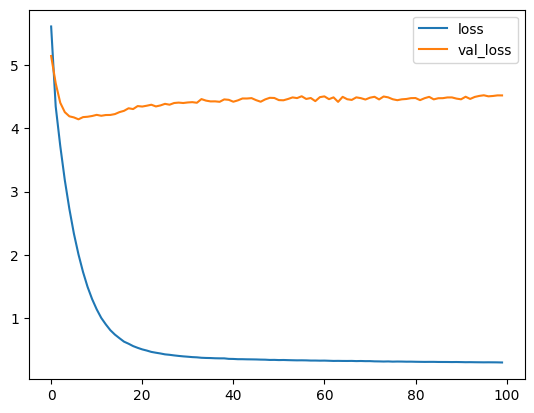

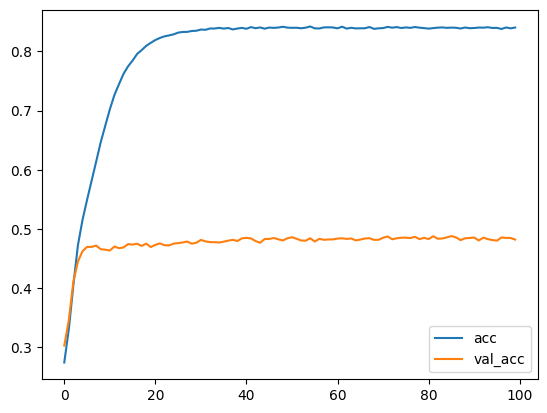

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('s2s.h5')

# Make predictions

In [ ]:
# As with the poetry example, we need to create another model that can take in the RNN state and previous word as input and accept a T=1 sequence.

# The encoder will be stand-alone, from this we will get our initial decoder hidden state

encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)

decoder_states = [h, c]

# Attention layer
attention = Attention()([decoder_outputs, encoder_outputs])
attention = Reshape((1, -1))(attention)  # Reshape attention for concatenation

# Concatenate attention output and decoder LSTM output
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense layer to produce softmax output
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)

decoder_model = Model(
  inputs=[decoder_inputs_single_x, encoder_outputs] + decoder_states_inputs,
  outputs=[decoder_outputs]+decoder_states
)

# map indexes back into real words so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
decoder_model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 1, 50)]              0         []                            
                                                                                                  
 input_40 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_41 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 lstm_1 (LSTM)               multiple                     314368    ['input_43[0][0]',            
                                                                     'input_40[0][0]',     

In [ ]:
# Make sure you have imported numpy as np
import numpy as np

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of the target sequence with the start character.
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # if we get this, we break
    eos = word2idx_outputs['<eos>']

    # Create the translation
    output_sentence = []
    attention_weights = []

    for _ in range(max_len_target):
        # Assuming your decoder model expects inputs in the following order:
        output_tokens = decoder_model.predict(
            [target_seq, attention] + states_value
        )

        print(output_tokens)

        # Get next word
        idx = np.argmax(output_tokens[0, 0, :])

        # End sentence if EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        target_seq[0, 0] = idx

        # Update states
        states_value = [h, c]

        # Store attention weights
        # attention_weights.append(attention_weights_timestep)

    return ' '.join(output_sentence)# np.array(attention_weights)


# Test Predictions

In [ ]:
# while True:
#   # Do some test translations
#   i = np.random.choice(len(input_texts))
#   input_seq = encoder_inputs[i:i+1]
#   print(encoder_outputs)
#   translation = decode_sequence(input_seq)
#   print('-')
#   print('Input:', input_texts[i])
#   print('Translation:', translation)

#   ans = input("Continue? [Y/n]")
#   if ans and ans.lower().startswith('n'):
#     break
file_path = '/content/sent_atten.txt'  # Replace with the actual path to your text file
with open(file_path, 'r') as file:
    # Read and print each line
    for line in file:
        print(line, end='')


1/1 [==============================] - 0s 20ms/step
-
Input: Tom spoke.
Translation: tom a parlé.
Continue? [Y/n]Y
1/1 [==============================] - 0s 19ms/step
-
Input: It's not mine.
Translation: ce n'est pas le mien.
Continue? [Y/n]Y
1/1 [==============================] - 0s 20ms/step
-
Input: Let Tom in.
Translation: laisse tom entrer.
Continue? [Y/n]Y
1/1 [==============================] - 0s 18ms/step
-
Input: Remain calm.
Translation: reste calme.
Continue? [Y/n]Y
1/1 [==============================] - 0s 18ms/step
-
Input: Stay calm.
Translation: reste cool.
Continue? [Y/n]Y
1/1 [==============================] - 0s 19ms/step
-
Input: Have a cookie.
Translation: avoir un biscuit !
Continue? [Y/n]Y
1/1 [==============================] - 0s 18ms/step
-
Input: It's no good.
Translation: ce n'est pas bon.
Continue? [Y/n]Y
1/1 [==============================] - 0s 20ms/step
-
Input: It's a weapon.
Translation: c'est un gaspillage.
Continue? [Y/n]Y
1/1 [========================

Attention Graphs

In [ ]:
sentences = [
    "Hello, how are you?",
]
# Tokenize and pad input sentences
input_sequences = tokenizer_inputs.texts_to_sequences(sentences)
encoder_inputs_test = pad_sequences(input_sequences, maxlen=max_len_input)

# Initialize decoder input with '<sos>' for each sentence
decoder_inputs_test = np.zeros((len(sentences), 1))
decoder_inputs_test[:, 0] = word2idx_outputs['<sos>']

# Predict translations
predicted_translations = model.predict([encoder_inputs_test, decoder_inputs_test])

# Get attention weights
attention_weights_test = model.predict([encoder_inputs_test, decoder_inputs_test])

# Visualize attention maps
for i in range(len(sentences)):
    # Plot attention weights
    plt.imshow(attention_weights_test[i].reshape((1, -1)), cmap='viridis', aspect='auto')
    plt.xlabel('Encoder Time Steps')
    plt.ylabel('Decoder Time Steps')
    plt.title(f'Attention Map for Sentence {i + 1}')
    plt.show()

    # Display the original sentence and predicted translation
    print(f"Input Sentence: {sentences[i]}")
    print(f"Predicted Translation: {tokenizer_outputs.sequences_to_texts([np.argmax(predicted_translations[i], axis=1)])[0]}\n")

# seq2seq Without Attention

In [ ]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)

def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

  # Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/100
125/125 [==============================] - 9s 52ms/step - loss: 5.6575 - acc: 0.2725 - val_loss: 5.2618 - val_acc: 0.2767
Epoch 2/100
125/125 [==============================] - 2s 19ms/step - loss: 4.5473 - acc: 0.3043 - val_loss: 4.8816 - val_acc: 0.2937
Epoch 3/100
125/125 [==============================] - 2s 16ms/step - loss: 4.0410 - acc: 0.3592 - val_loss: 4.5707 - val_acc: 0.3676
Epoch 4/100
125/125 [==============================] - 2s 18ms/step - loss: 3.5819 - acc: 0.4371 - val_loss: 4.3249 - val_acc: 0.4244
Epoch 5/100
125/125 [==============================] - 2s 17ms/step - loss: 3.1992 - acc: 0.4810 - val_loss: 4.1919 - val_acc: 0.4474
Epoch 6/100
125/125 [==============================] - 2s 18ms/step - loss: 2.8934 - acc: 0.5114 - val_loss: 4.0999 - val_acc: 0.4630
Epoch 7/100
125/125 [==============================] - 2s 15ms/step - loss: 2.6288 - acc: 0.5339 - val_loss: 4.0887 - val_acc: 0.4685
Epoch 8/100
125/125 [==============================] - 2s 15ms

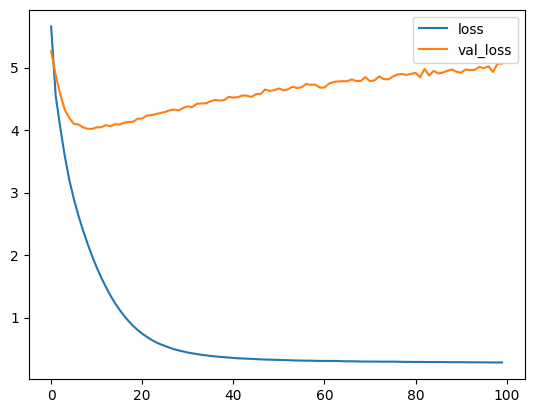

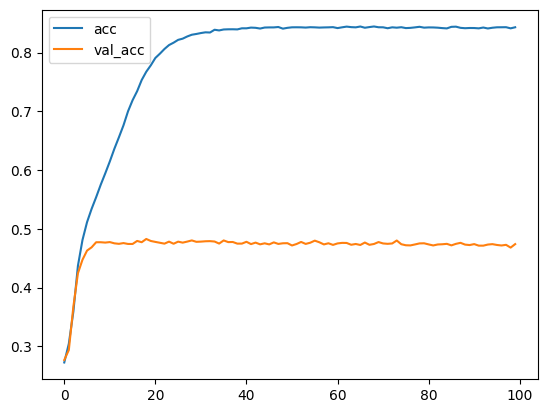

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('s2s.h5')

In [ ]:
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs,
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)


### Testing without attention

In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

1/1 [==============================] - 0s 20ms/step
-
Input: Tom spoke.
Translation: tom a parlé.
Continue? [Y/n]Y
1/1 [==============================] - 0s 19ms/step
-
Input: It's not mine.
Translation: il n'est pas à moi.
Continue? [Y/n]Y
1/1 [==============================] - 0s 20ms/step
-
Input: Let Tom in.
Translation: fais entrer tom.
Continue? [Y/n]Y
1/1 [==============================] - 0s 18ms/step
-
Input: Remain calm.
Translation: gardez votre calme.
Continue? [Y/n]Y
1/1 [==============================] - 0s 18ms/step
-
Input: Stay calm.
Translation: on reste cool.
Continue? [Y/n]Y
1/1 [==============================] - 0s 19ms/step
-
Input: Have a cookie.
Translation: prends un biscuit !
Continue? [Y/n]Y
1/1 [==============================] - 0s 18ms/step
-
Input: It's no good.
Translation: ce n'est pas bon.
Continue? [Y/n]Y
1/1 [==============================] - 0s 20ms/step
-
Input: It's a weapon.
Translation: c'est un gaspillage.
Continue? [Y/n]Y
1/1 [=================